In [1]:
!pip install jupyter ipykernel
!pip install pandas polars pyarrow matplotlib seaborn scikit-learn lightgbm
!python -m ipykernel install --user --name=project_taxi_polars --display-name "Python (project_taxi_polars)"

Installed kernelspec project_taxi_polars in C:\Users\a.palacio\AppData\Roaming\jupyter\kernels\project_taxi_polars


In [2]:
import pandas as pd
import polars as pl
import seaborn as sns
import time
import matplotlib.pyplot as plt
FILE = "./yellow_tripdata_2025-01.parquet"  # dataset NYC taxi

def pandas_flow(file):
    start = time.perf_counter()
    df = pd.read_parquet(file)   # 👈 CAMBIO

    # limpieza
    df = df.dropna(subset=["passenger_count", "total_amount"])
    df = df.drop_duplicates()
    df = df[df["total_amount"] > 0]

    # transformación
    df["pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    df["trip_duration"] = (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds() / 60

    result = df.groupby(df["pickup_datetime"].dt.month).agg({
        "trip_duration": "mean",
        "total_amount": "sum",
        "passenger_count": "count"
    }).rename(columns={"passenger_count": "total_trips"}).reset_index()

    end = time.perf_counter()
    return result, end - start


def polars_flow(file):
    start = time.perf_counter()
    df = pl.read_parquet(file)   # 👈 CAMBIO

    # limpieza
    df = df.drop_nulls(["passenger_count", "total_amount"])
    df = df.unique()
    df = df.filter(pl.col("total_amount") > 0)

    # transformación
    df = df.with_columns([
        (pl.col("tpep_dropoff_datetime").cast(pl.Datetime) - pl.col("tpep_pickup_datetime").cast(pl.Datetime)).dt.seconds() / 60
        .alias("trip_duration"),
        pl.col("tpep_pickup_datetime").cast(pl.Datetime).dt.month().alias("month")
    ])

    result = df.groupby("month").agg([
        pl.mean("trip_duration").alias("avg_trip_duration"),
        pl.sum("total_amount").alias("total_revenue"),
        pl.count("passenger_count").alias("total_trips")
    ])
    end = time.perf_counter()
    return result, end - start
pandas_flow(FILE)



(   pickup_datetime  trip_duration  total_amount  total_trips
 0                1      14.981892   79790783.20      2874927
 1                2       4.666667         22.13            1
 2               12      16.805556        589.17           21,
 6.413526800002728)

✅ Pandas result:
   month  avg_trip_duration  total_revenue  total_trips
0      1          14.981892    79790783.20      2874927
1      2           4.666667          22.13            1
2     12          16.805556         589.17           21 

✅ Polars result:
shape: (3, 4)
┌───────┬───────────────────┬───────────────┬─────────────┐
│ month ┆ avg_trip_duration ┆ total_revenue ┆ total_trips │
│ ---   ┆ ---               ┆ ---           ┆ ---         │
│ i8    ┆ f64               ┆ f64           ┆ u32         │
╞═══════╪═══════════════════╪═══════════════╪═════════════╡
│ 1     ┆ 14.981892         ┆ 7.9791e7      ┆ 2874927     │
│ 2     ┆ 4.666667          ┆ 22.13         ┆ 1           │
│ 12    ┆ 16.805556         ┆ 589.17        ┆ 21          │
└───────┴───────────────────┴───────────────┴─────────────┘ 

⏱️ Pandas time: 5.85 s
⏱️ Polars time: 2.24 s


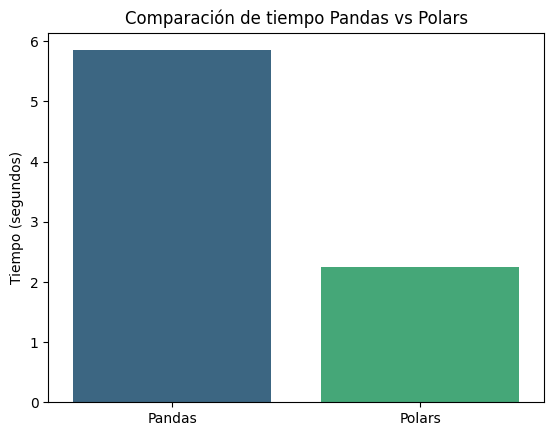

In [3]:
!pip install fastparquet

import pandas as pd
import polars as pl
import time
import matplotlib.pyplot as plt
import seaborn as sns

FILE = "./yellow_tripdata_2025-01.parquet"  # tu dataset NYC taxi


# --- ⚡ Flujo con Pandas ---
def pandas_flow(file):
    start = time.perf_counter()

    df = pd.read_parquet(file, engine="fastparquet")

    # limpieza
    df = df.dropna(subset=["passenger_count", "total_amount"])
    df = df.drop_duplicates()
    df = df[df["total_amount"] > 0]

    # transformación
    df["pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    df["trip_duration"] = (
        (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds() / 60
    )

    # agrupación
    result = (
        df.groupby(df["pickup_datetime"].dt.month)
        .agg(
            avg_trip_duration=("trip_duration", "mean"),
            total_revenue=("total_amount", "sum"),
            total_trips=("passenger_count", "count"),
        )
        .reset_index(names="month")
    )

    end = time.perf_counter()
    return result, end - start


# --- ⚡ Flujo con Polars ---
def polars_flow(file):
    start = time.perf_counter()

    df = pl.read_parquet(file)

    # limpieza
    df = df.drop_nulls(["passenger_count", "total_amount"])
    df = df.unique()
    df = df.filter(pl.col("total_amount") > 0)

    # transformación + agrupación
    df = df.with_columns(
        [
            (
                (pl.col("tpep_dropoff_datetime").cast(pl.Datetime) -
                 pl.col("tpep_pickup_datetime").cast(pl.Datetime))
                .dt.total_seconds() / 60
            ).alias("trip_duration"),
            pl.col("tpep_pickup_datetime").cast(pl.Datetime).dt.month().alias("month"),
        ]
    )

    result = (
    df.group_by("month")
    .agg(
        [
            pl.mean("trip_duration").alias("avg_trip_duration"),
            pl.sum("total_amount").alias("total_revenue"),
            pl.count("passenger_count").alias("total_trips"),
        ]
    )
    .sort("month")

    )

    end = time.perf_counter()
    return result, end - start


# --- 🚀 Ejecutar ambos flujos ---
pd_result, pd_time = pandas_flow(FILE)
pl_result, pl_time = polars_flow(FILE)

print("✅ Pandas result:")
print(pd_result.head(), "\n")
print("✅ Polars result:")
print(pl_result.head(), "\n")

print(f"⏱️ Pandas time: {pd_time:.2f} s")
print(f"⏱️ Polars time: {pl_time:.2f} s")


# --- 📊 Dashboard de comparación ---
times = {"Pandas": pd_time, "Polars": pl_time}
sns.barplot(
    x=list(times.keys()),
    y=list(times.values()),
    hue=list(times.keys()),   # usar x como hue
    palette="viridis",
    legend=False
)
plt.ylabel("Tiempo (segundos)")
plt.title("Comparación de tiempo Pandas vs Polars")
plt.show()


In [4]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# La ruta usa ../ para "subir un nivel" desde la carpeta notebooks a la raíz del proyecto
FILE = "./yellow_tripdata_2025-01.parquet"  # dataset NYC taxi

df = pl.read_parquet(FILE)

df.head()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,datetime[μs],datetime[μs],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2025-01-01 00:18:38,2025-01-01 00:26:59,1,1.6,1,"""N""",229,237,1,10.0,3.5,0.5,3.0,0.0,1.0,18.0,2.5,0.0,0.0
1,2025-01-01 00:32:40,2025-01-01 00:35:13,1,0.5,1,"""N""",236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
1,2025-01-01 00:44:04,2025-01-01 00:46:01,1,0.6,1,"""N""",141,141,1,5.1,3.5,0.5,2.0,0.0,1.0,12.1,2.5,0.0,0.0
2,2025-01-01 00:14:27,2025-01-01 00:20:01,3,0.52,1,"""N""",244,244,2,7.2,1.0,0.5,0.0,0.0,1.0,9.7,0.0,0.0,0.0
2,2025-01-01 00:21:34,2025-01-01 00:25:06,3,0.66,1,"""N""",244,116,2,5.8,1.0,0.5,0.0,0.0,1.0,8.3,0.0,0.0,0.0


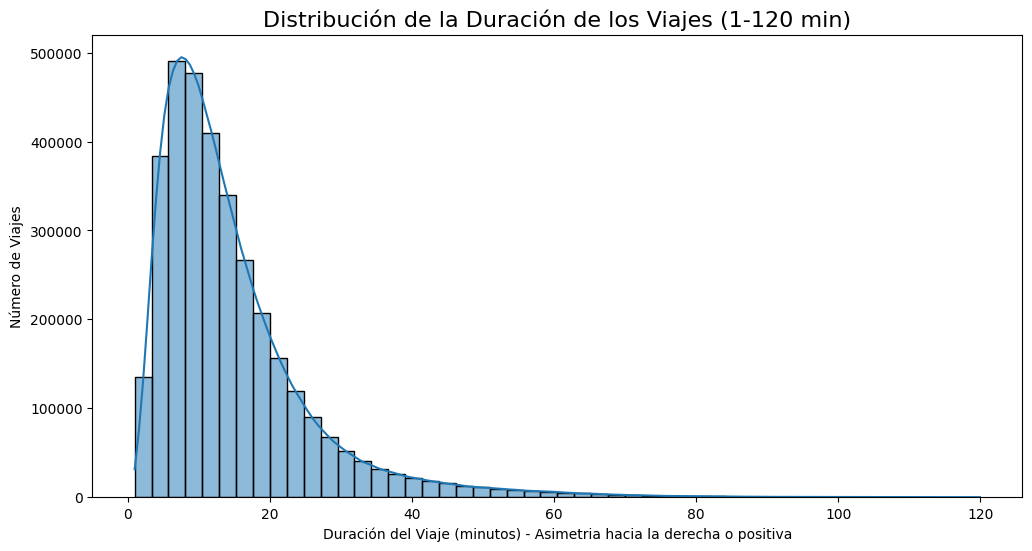

In [5]:
# 1. Calcular la duración del viaje en minutos
df = df.with_columns(
    trip_duration = (
        (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).dt.total_seconds() / 60
    )
)

# 2. Filtrar outliers para una mejor visualización. Viajes de más de 2 horas o menos de 1 min
#    probablemente son errores o casos muy extraños.
df_filtered = df.filter(pl.col("trip_duration").is_between(1, 120))

# 3. Visualizar la distribución con un histograma
plt.figure(figsize=(12, 6))
sns.histplot(data=df_filtered.to_pandas(), x="trip_duration", bins=50, kde=True)
plt.title("Distribución de la Duración de los Viajes (1-120 min)", fontsize=16)
plt.xlabel("Duración del Viaje (minutos) - Asimetria hacia la derecha o positiva")
plt.ylabel("Número de Viajes")
plt.show()

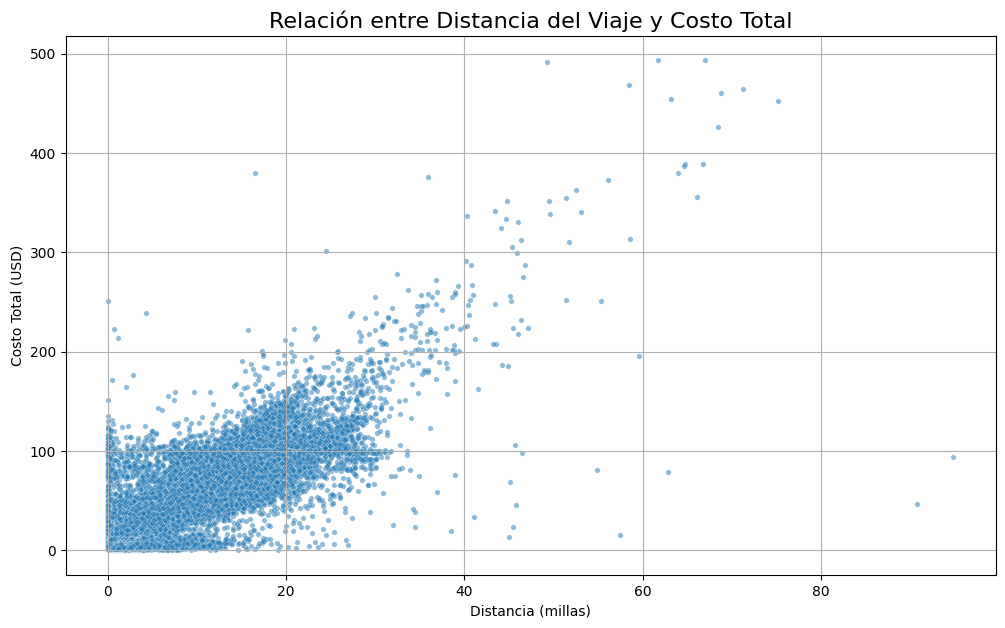

In [6]:
# --- ANÁLISIS 2: DISTANCIA VS. COSTO ---

# Filtramos outliers extremos para una mejor visualización
# (ej. distancias > 100 millas o costos > $500 son raros y distorsionan la escala)
df_sample = df.filter(
    (pl.col("trip_distance") > 0) & (pl.col("trip_distance") < 100) &
    (pl.col("total_amount") > 0) & (pl.col("total_amount") < 500)
)

# Tomamos una muestra aleatoria del 10% para que el gráfico sea más rápido y legible
# El parámetro `fraction` indica el porcentaje de datos a tomar.
# `with_replacement=False` asegura que no se repitan filas.
df_sample = df_sample.sample(fraction=0.1, with_replacement=False, seed=1)

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_sample.to_pandas(), 
    x="trip_distance", 
    y="total_amount", 
    alpha=0.5, # La transparencia ayuda a ver la densidad de puntos
    s=15      # Tamaño de los puntos
)

plt.title("Relación entre Distancia del Viaje y Costo Total", fontsize=16)
plt.xlabel("Distancia (millas)")
plt.ylabel("Costo Total (USD)")
plt.grid(True)
plt.show()

### Principales Insights del Gráfico de Dispersión

Del análisis de distancia vs. costo, se extraen tres conclusiones clave:

* **Validación del Negocio:** Se confirma una **fuerte correlación positiva** entre la distancia y el costo total, lo que valida la lógica principal del negocio. La mayoría de los puntos siguen una tendencia lineal clara.

* **Detección de Reglas Específicas:** La presencia de **líneas horizontales** de puntos evidencia la existencia de **tarifas planas** para rutas específicas (probablemente a aeropuertos), revelando que el modelo de precios no es puramente basado en distancia.

* **Identificación de Datos Anómalos:** El gráfico expone claros problemas de calidad de datos que deben ser tratados. Destacan los viajes con **distancia cero pero con costo (outliers verticales)** y viajes **largos con costo casi nulo (outliers horizontales)**, los cuales son candidatos a ser filtrados en la etapa de preprocesamiento.

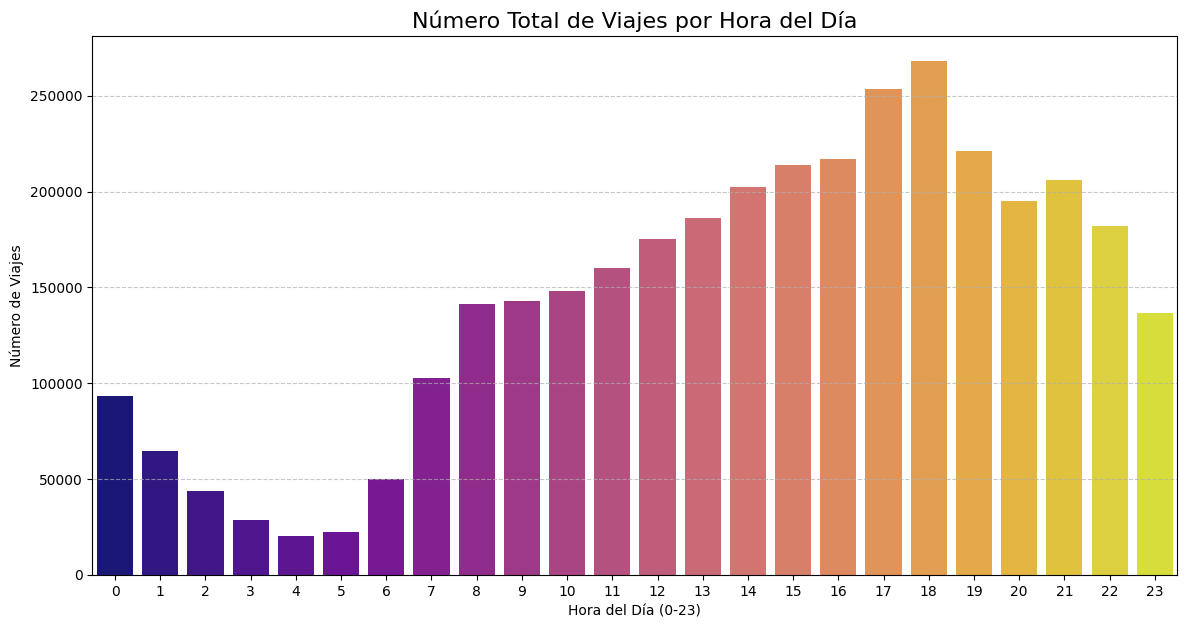

In [7]:
# --- ANÁLISIS 3: NÚMERO DE VIAJES POR HORA DEL DÍA ---

# Paso 1: Extraer la hora de la columna de fecha y hora.
# Creamos una nueva columna llamada 'pickup_hour'.
df = df.with_columns(
    pickup_hour = pl.col("tpep_pickup_datetime").dt.hour()
)

# Paso 2: Agrupar por hora y contar el número de viajes en cada grupo.
# Luego, lo ordenamos por hora para que el gráfico tenga sentido.
trips_by_hour = (
    df.group_by("pickup_hour")
    .agg(
        pl.len().alias("num_trips")  # pl.count() cuenta todas las filas del grupo
    )
    .sort("pickup_hour")
)

# Paso 3: Visualizar los resultados con un gráfico de barras.
plt.figure(figsize=(14, 7))
# CÓDIGO CORREGIDO
sns.barplot(
    data=trips_by_hour.to_pandas(), 
    x="pickup_hour", 
    y="num_trips",
    palette="plasma",
    hue="pickup_hour",    # 1. Le dices que el color depende de la hora (la misma variable 'x')
    legend=False          # 2. Ocultas la leyenda, que no es necesaria en este caso
)

plt.title("Número Total de Viajes por Hora del Día", fontsize=16)
plt.xlabel("Hora del Día (0-23)")
plt.ylabel("Número de Viajes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Este gráfico es muy fácil de interpretar y casi siempre revela un patrón claro del ritmo de una ciudad:

Pico de la Mañana (Morning Rush): Verás un aumento significativo en el número de viajes por la mañana (generalmente entre las 7 y 9 AM), que corresponde a la gente yendo a trabajar.

Valle del Mediodía: Es común ver una ligera caída o una meseta en las horas del mediodía y la tarde temprana.

Pico de la Tarde/Noche (Evening Rush): El pico más grande suele ocurrir al final de la jornada laboral y comienzo de la noche (entre las 5 y 8 PM), cuando la gente vuelve a casa, va a cenar o sale a eventos.

Madrugada: Verás la menor cantidad de viajes durante las horas de la madrugada (ej. 2-5 AM).

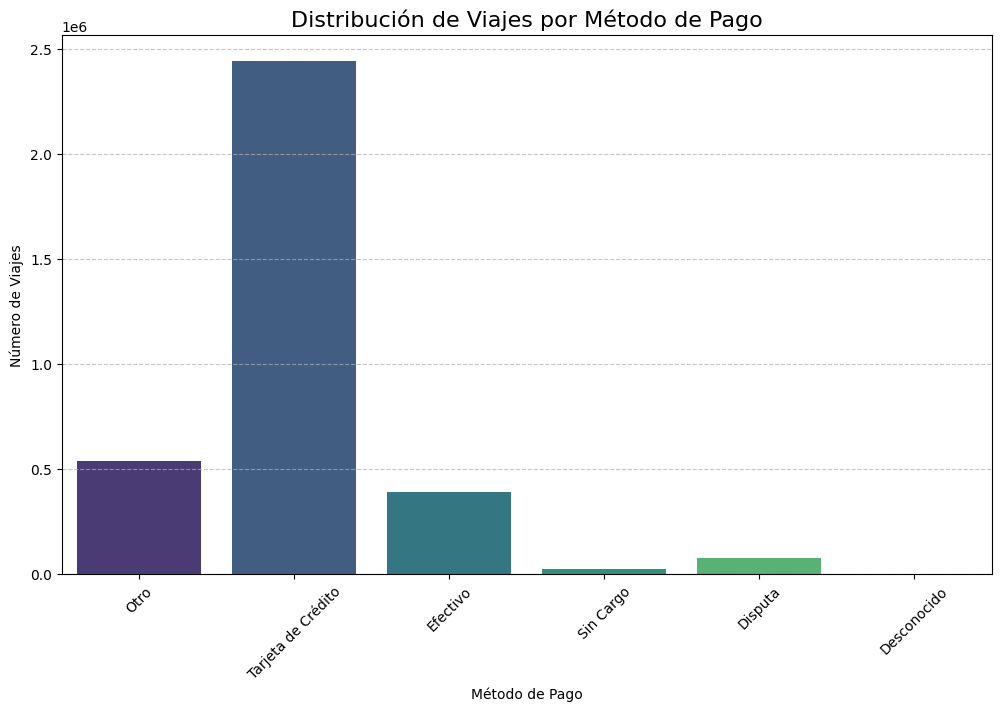

In [8]:
# --- ANÁLISIS 4: MÉTODOS DE PAGO MÁS COMUNES (CON WHEN/THEN) ---

# Paso 1: Agrupar por 'payment_type' y contar los viajes.
payment_counts = (
    df.group_by("payment_type")
    .agg(
        pl.len().alias("num_trips")
    )
    .sort("payment_type")
)

# Paso 2: Mapear los números a etiquetas usando la expresión 'when/then'.
# Esta es la forma más robusta de hacerlo en Polars.
payment_counts = payment_counts.with_columns(
    payment_label = (
        pl.when(pl.col("payment_type") == 1).then(pl.lit("Tarjeta de Crédito"))
        .when(pl.col("payment_type") == 2).then(pl.lit("Efectivo"))
        .when(pl.col("payment_type") == 3).then(pl.lit("Sin Cargo"))
        .when(pl.col("payment_type") == 4).then(pl.lit("Disputa"))
        .when(pl.col("payment_type") == 5).then(pl.lit("Desconocido"))
        .when(pl.col("payment_type") == 6).then(pl.lit("Viaje Cancelado"))
        .otherwise(pl.lit("Otro")) # Captura cualquier otro valor inesperado
    )
)

# Paso 3: Visualizar los resultados.
plt.figure(figsize=(12, 7))
sns.barplot(
    data=payment_counts.to_pandas(),
    x="payment_label",
    y="num_trips",
    palette="viridis",
    hue="payment_label",
    legend=False
)

plt.title("Distribución de Viajes por Método de Pago", fontsize=16)
plt.xlabel("Método de Pago")
plt.ylabel("Número de Viajes")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
# --- INGENIERÍA DE CARACTERÍSTICAS ---

print("Shape original:", df.shape)

df = df.with_columns(
    # Extraer el día de la semana (1=Lunes, 7=Domingo)
    day_of_week = pl.col("tpep_pickup_datetime").dt.weekday(),
)

# Crear una feature que indique si es fin de semana o no
df = df.with_columns(
    is_weekend = pl.when(pl.col("day_of_week").is_in([6, 7])).then(1).otherwise(0)
)

print("Shape con nuevas features:", df.shape)
df.head(3)

Shape original: (3475226, 22)
Shape con nuevas features: (3475226, 24)


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,trip_duration,pickup_hour,day_of_week,is_weekend
i32,datetime[μs],datetime[μs],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i32
1,2025-01-01 00:18:38,2025-01-01 00:26:59,1,1.6,1,"""N""",229,237,1,10.0,3.5,0.5,3.0,0.0,1.0,18.0,2.5,0.0,0.0,8.35,0,3,0
1,2025-01-01 00:32:40,2025-01-01 00:35:13,1,0.5,1,"""N""",236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0,2.55,0,3,0
1,2025-01-01 00:44:04,2025-01-01 00:46:01,1,0.6,1,"""N""",141,141,1,5.1,3.5,0.5,2.0,0.0,1.0,12.1,2.5,0.0,0.0,1.95,0,3,0


In [10]:
# --- PREPARACIÓN FINAL DEL DATASET ---

# Definir las columnas que usaremos en el modelo
features = [
    "passenger_count",
    "trip_distance",
    "PULocationID",
    "DOLocationID",
    "payment_type",
    "pickup_hour",
    "day_of_week",
    "is_weekend"
]
target = "trip_duration"

# Aplicar filtros para eliminar outliers y datos inconsistentes
model_df = df.filter(
    (pl.col("trip_duration").is_between(1, 120)) & # Duración entre 1 y 120 minutos
    (pl.col("trip_distance") > 0) &               # Distancia mayor a cero
    (pl.col("passenger_count") > 0)                # Pasajeros mayor a cero
)

# Seleccionar solo las columnas necesarias
model_df = model_df.select(features + [target])

print(f"Dataset listo para entrenar con {model_df.height} filas y {model_df.width} columnas.")
model_df.head()

Dataset listo para entrenar con 2857857 filas y 9 columnas.


passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,pickup_hour,day_of_week,is_weekend,trip_duration
i64,f64,i32,i32,i64,i8,i8,i32,f64
1,1.6,229,237,1,0,3,0,8.35
1,0.5,236,237,1,0,3,0,2.55
1,0.6,141,141,1,0,3,0,1.95
3,0.52,244,244,2,0,3,0,5.566667
3,0.66,244,116,2,0,3,0,3.533333


In [11]:
# --- ENTRENAMIENTO DEL MODELO BASELINE ---
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# 1. Separar features (X) y objetivo (y)
X = model_df.select(features).to_pandas() # Scikit-learn trabaja mejor con Pandas/Numpy
y = model_df.select(target).to_pandas()

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entrenar el modelo
print("Entrenando modelo LightGBM...")
model = LGBMRegressor(random_state=42)

# LightGBM puede manejar columnas categóricas directamente si se lo indicamos
categorical_features = ["PULocationID", "DOLocationID", "payment_type", "day_of_week", "is_weekend"]
# Convertimos esas columnas al tipo 'category' para que LightGBM las reconozca
X_train[categorical_features] = X_train[categorical_features].astype("category")
X_test[categorical_features] = X_test[categorical_features].astype("category")

model.fit(X_train, y_train)

# 4. Evaluar el modelo
print("Evaluando modelo...")
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"✅ ¡Modelo entrenado! El RMSE en el conjunto de prueba es: {rmse:.2f} minutos.")

Entrenando modelo LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 2286285, number of used features: 8
[LightGBM] [Info] Start training from score 14.618515
Evaluando modelo...
✅ ¡Modelo entrenado! El RMSE en el conjunto de prueba es: 4.49 minutos.


El modelo, entrenado con más de 2.2 millones de viajes, ahora puede predecir la duración de un trayecto con un **error promedio de solo 4.49 minutos (RMSE)**. Partiendo de una estimación inicial de 14.6 minutos (la duración promedio de todos los viajes), el modelo aprendió exitosamente los patrones de las 8 características proporcionadas, logrando una predicción significativamente precisa para un entorno tan variable como el tráfico de Nueva York.

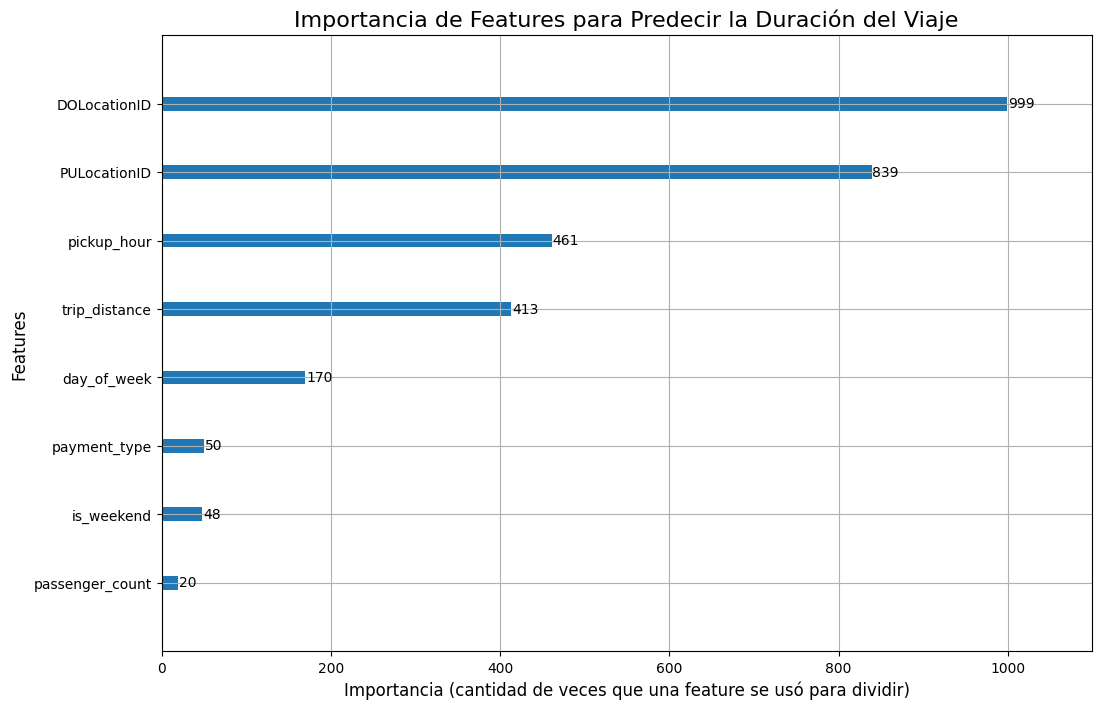

In [14]:
# --- ANÁLISIS DE IMPORTANCIA DE FEATURES ---
import matplotlib.pyplot as plt
import lightgbm as lgb

ax = lgb.plot_importance(model, figsize=(12, 8), max_num_features=10)

plt.title("Importancia de Features para Predecir la Duración del Viaje", fontsize=16)
plt.xlabel("Importancia (cantidad de veces que una feature se usó para dividir)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(True)

# --- AÑADE ESTA LÍNEA PARA GUARDAR LA IMAGEN ---
plt.savefig('feature_importance.png', bbox_inches='tight') # bbox_inches='tight' evita que la imagen se corte

plt.show()

In [15]:
import joblib
import os

# Crear la carpeta 'models' si no existe
if not os.path.exists('models'):
    os.makedirs('models')

# Guardar el modelo entrenado
joblib.dump(model, "models/lgbm_duration_model.joblib")
print("Modelo guardado en 'models/lgbm_duration_model.joblib'")

Modelo guardado en 'models/lgbm_duration_model.joblib'


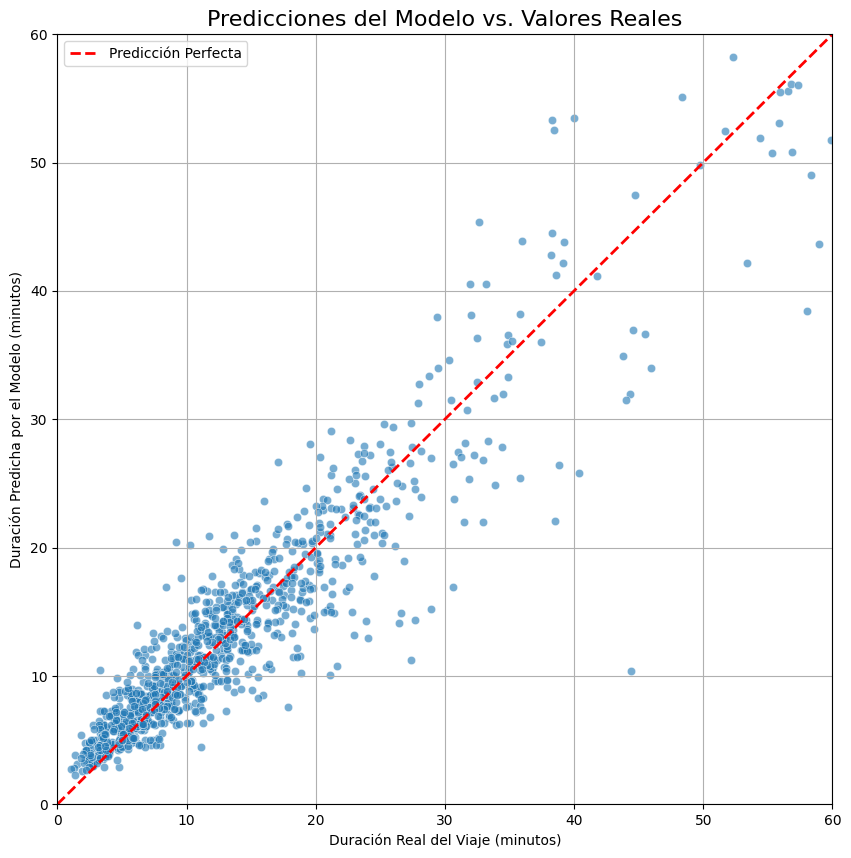

In [16]:
# --- MÉTODO 2: GRÁFICO DE PREDICCIONES VS. REALES ---

# Creemos un DataFrame para facilitar la visualización
results_df = pd.DataFrame({
    'Valor Real': y_test['trip_duration'],
    'Predicción': predictions
})

# Para que el gráfico sea legible, tomaremos una muestra de los resultados
results_sample = results_df.sample(n=1000, random_state=42)

plt.figure(figsize=(10, 10))
sns.scatterplot(data=results_sample, x='Valor Real', y='Predicción', alpha=0.6)
# Dibujamos la línea de 45 grados que representa la predicción perfecta
plt.plot([0, 60], [0, 60], color='red', linestyle='--', lw=2, label='Predicción Perfecta')
plt.title('Predicciones del Modelo vs. Valores Reales', fontsize=16)
plt.xlabel('Duración Real del Viaje (minutos)')
plt.ylabel('Duración Predicha por el Modelo (minutos)')
plt.xlim(0, 60) # Limitamos los ejes para una mejor visualización
plt.ylim(0, 60)
plt.legend()
plt.grid(True)
plt.show()

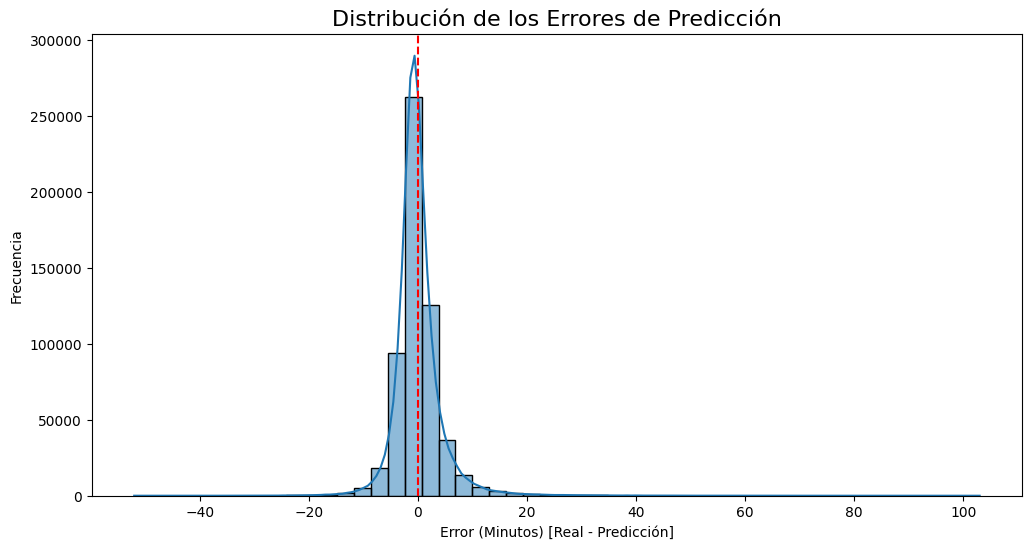

In [17]:
# --- MÉTODO 3: HISTOGRAMA DE ERRORES ---

# Calcular los errores
errors = y_test['trip_duration'] - predictions

plt.figure(figsize=(12, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title('Distribución de los Errores de Predicción', fontsize=16)
plt.xlabel('Error (Minutos) [Real - Predicción]')
plt.ylabel('Frecuencia')
# Dibujamos una línea vertical en cero para ver si los errores están centrados
plt.axvline(x=0, color='red', linestyle='--')
plt.show()